In [40]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.stats import genpareto
matplotlib.use('TkAgg')

from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from tqdm.notebook import trange, tqdm
#from anomaly_scoring import get_anomaly_scores

import torch
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%matplotlib inline 


from utils import get_taxi_data_VAE, get_taxi_data_cVAE
from utils import softclip
from utils import plot_train_test_reconstructions
from models.cnn_sigmaVAE import CNN_sigmaVAE

In [2]:
data = np.load('../../datasets/machine_temp.npz')

for k in data.files:
    print(k)
    
print(data['idx_anomaly_test'])

t
t_unit
readings
idx_anomaly
idx_split
training
test
train_m
train_std
t_train
t_test
idx_anomaly_test
[[2410 3987]
 [ 841 4016]]


torch.Size([40, 1, 128]) torch.Size([40, 1, 128])
torch.Size([40, 1, 128]) torch.Size([40, 1, 128])


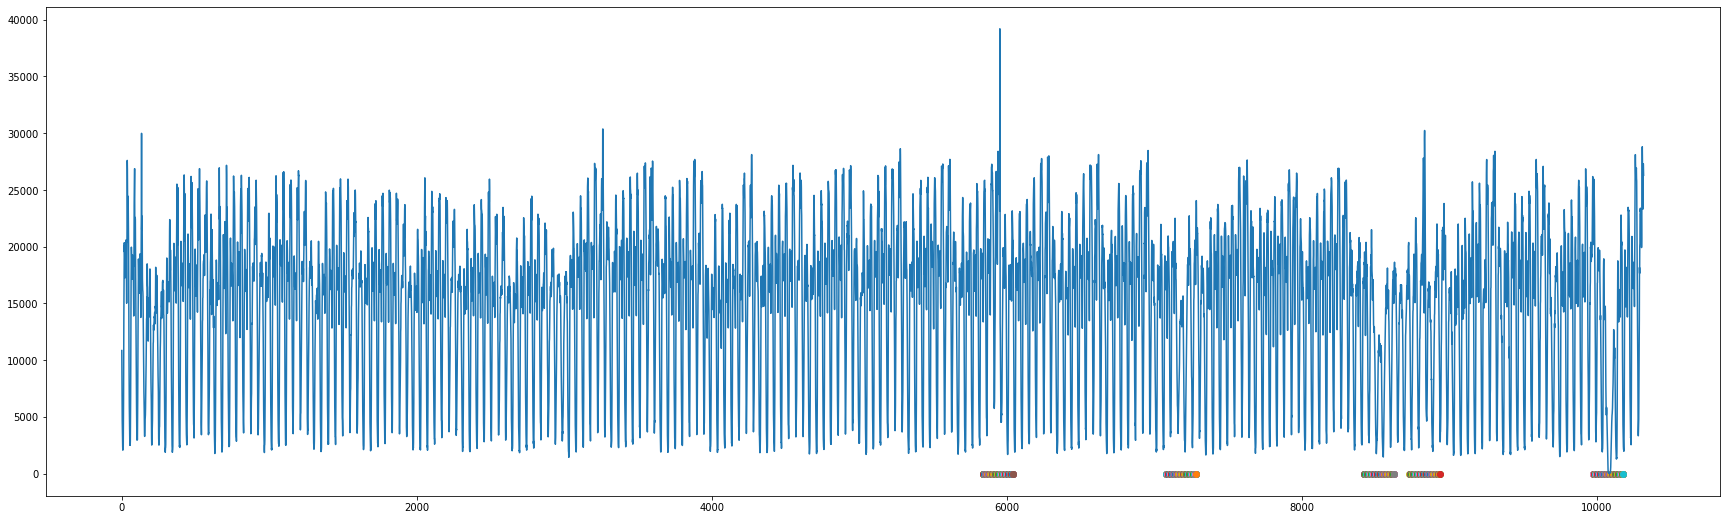

In [32]:
dataset_path = '../../datasets/nab/NAB-master/data/realKnownCause/nyc_taxi.csv'
#dataset_path = '../../datasets/nab/NAB-master/data/realKnownCause/machine_temperature_system_failure.csv'
#dataset_path = '../../datasets/nab/NAB-master/data/realKnownCause/ambient_temperature_system_failure.csv'
#dataset_path = '../../datasets/nab/NAB-master/data/realKnownCause/cpu_utilization_asg_misconfiguration.csv'
#dataset_path = '../../datasets/nab/NAB-master/data/realKnownCause/ec2_request_latency_system_failure.csv'


if 'nyc_taxi' in dataset_path:
    anomaly_timestamps = ["2014-11-01 19:00:00", "2014-11-27 15:30:00","2014-12-25 15:00:00","2015-01-01 01:00:00","2015-01-27 00:00:00"]

    anomaly_windows = [
        [
            "2014-10-30 15:30:00",
            "2014-11-03 22:30:00"
        ],
        [
            "2014-11-25 12:00:00",
            "2014-11-29 19:00:00"
        ],
        [
            "2014-12-23 11:30:00",
            "2014-12-27 18:30:00"
        ],
        [
            "2014-12-29 21:30:00",
            "2015-01-03 04:30:00"
        ],
        [
            "2015-01-24 20:30:00",
            "2015-01-29 03:30:00"
        ]
    ]
    
elif 'ambient_temperature_system_failure' in dataset_path:
    anomaly_timestamps = ["2013-12-22 20:00:00","2014-04-13 09:00:00"]

elif 'cpu_utilization_asg_misconfiguration' in dataset_path:
    anomaly_timestamps = ["2014-07-12 02:04:00","2014-07-14 21:44:00"]

elif 'ec2_request_latency_system_failure' in dataset_path:
    anomaly_timestamps = ["2014-03-14 09:06:00","2014-03-18 22:41:00","2014-03-21 03:01:00"]

elif 'machine_temperature_system_failure' in dataset_path:
    anomaly_timestamps = ["2013-12-11 06:00:00","2013-12-16 17:25:00","2014-01-28 13:55:00","2014-02-08 14:30:00"]

    

    
#singular anomaly points
'''
window_size=128
X_train_data, X_test_data, X_train_tensor, X_test_tensor, trainloader, testloader = get_taxi_data_VAE(dataset_path,window_size=window_size,train_test_split=.5) 

data = pd.read_csv(dataset_path)

timestamps = list(pd.read_csv(dataset_path)['timestamp'])
    
anomaly_idxs = []
for timestamp in anomaly_timestamps:
    start = timestamp

    loc_start = timestamps.index(start)
    anomaly_idxs.append(loc_start)
    
anomaly_idxs = np.array(anomaly_idxs)    
'''



#anomaly windows code -- not used currently -- what are anomaly windows in nab??

window_size=128
X_train_data, X_test_data, X_train_tensor, X_test_tensor, trainloader, testloader = get_taxi_data_VAE(dataset_path,window_size=window_size,train_test_split=.5) 

data = pd.read_csv(dataset_path)

timestamps = list(pd.read_csv(dataset_path)['timestamp'])

anomaly_idxs = []
for timestamp in anomaly_windows:
    start, end = timestamp[0], timestamp[1]

    loc_start = timestamps.index(start)
    loc_end = timestamps.index(end)

    for i in range(loc_start, loc_end):
        anomaly_idxs.append(i)

anomaly_idxs = np.array(anomaly_idxs)
anomaly_idxs = anomaly_idxs[anomaly_idxs > 0]

plt.figure(figsize=(30,9))
for ai in anomaly_idxs:
    plt.scatter(ai, 1.7)


plt.plot(data['value'])
plt.show()


In [33]:
print(len(X_train_data))
print(len(X_test_data))


5160
5160


In [34]:
def train_flow_model(model, num_epochs, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    epochs=num_epochs
    tq = tqdm(range(epochs))
    for epoch in tq:
        flag = False
        for j, data in enumerate(trainloader, 0):

            optimizer.zero_grad()

            #batches
            inputs, labels = data
            inputs = inputs.cuda() if torch.cuda.is_available() else inputs.cpu()
            inputs.to(device)
            labels = labels.cuda() if torch.cuda.is_available() else labels.cpu()
            labels.to(device)

            outputs, rec_mu, rec_sigma, kl = model(inputs)

            rec_comps, rec, rec_mu_sigma_loss, kl = model.loss_function(outputs, labels, rec_mu, rec_sigma, kl)

            loss = rec + kl + rec_mu_sigma_loss

            if(np.isnan(loss.item())):
                print("Noped out at", epoch, j, kl, rec_comps)
                flag = True
                break

            loss.backward()
            optimizer.step()
        if(flag):
            break
        tq.set_postfix(loss=loss.item())
        #print(epoch, 'total :' + str(loss.item()) + ' rec : ' + str(rec.item()) + ' kl : ' + str(kl.sum().item()) + ' sigma: ' + str(model.log_sigma.item()))

        #break
    return model

In [35]:
model = CNN_sigmaVAE(latent_dim=8, window_size=128, use_probabilistic_decoder=False)
model.to(device)
model.cuda() if torch.cuda.is_available() else model.cpu()

model = train_flow_model(model, 2000, .001)

torch.Size([40, 1, 128])
torch.Size([40, 1, 128])
(40, 1, 128)


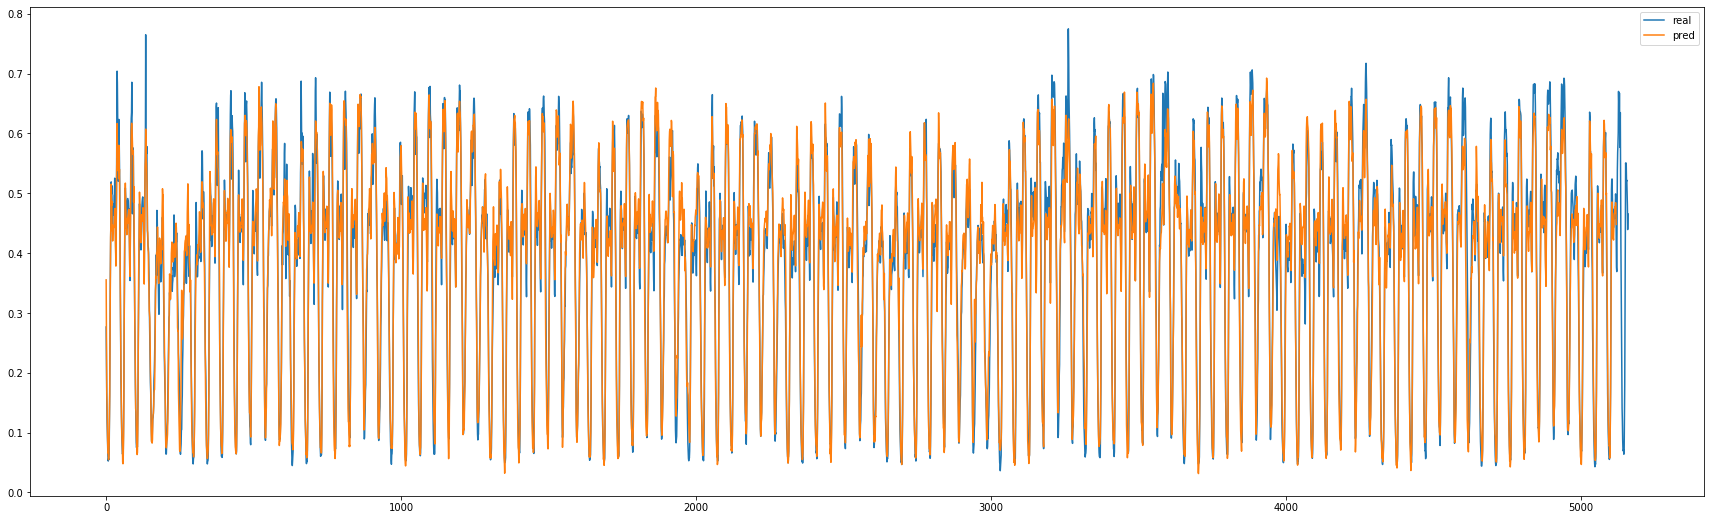

MSE : 6.907
(40, 1, 128)


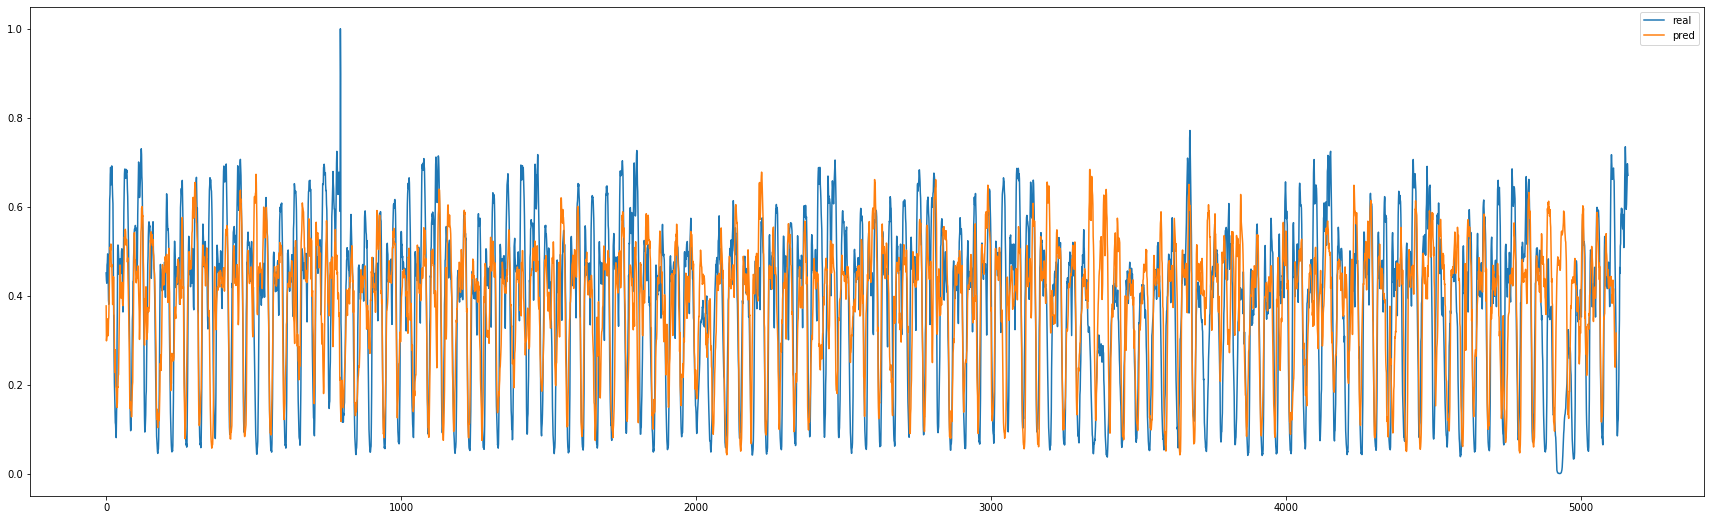

MSE : 128.765


In [36]:
print(X_test_tensor.shape)
print(X_train_tensor.shape)

plot_train_test_reconstructions(model, X_train_tensor, X_train_data, X_test_tensor,X_test_data) 


In [37]:
def evaluate_model(model, X_tensor):
    
    X_tensor = X_tensor.cuda() if torch.cuda.is_available() else X_tensor.cpu()
    X_tensor.to(device)
    out_pred, _,_,_= model(X_tensor)
    out_pred = out_pred.cpu().detach().numpy()

    idx = 0
    preds = []
    for i in range(len(out_pred)):
        for j in out_pred[i,0]:
            preds.append(j)

    preds = np.array(preds)
    
    return preds

'''
returns adjusted predictions (like DONUT method) (all others paper use this I believe also)
'''
def evaluate_anomalies(real, scores, thresh):
    
    pointwise_alerts = np.array([1 if scores[i] > thresh else 0 for i in range(len(scores))])

    anomaly_windows = []
    i = 0
    while i < len(real):
        if real[i] == 1:
            j = i
            while(j < len(real)):
                if real[j] == 0:
                    anomaly_windows.append([i,j])
                    break
                j+=1

                if j == len(real)-1 and real[j] == 1:
                    anomaly_windows.append([i,j+1])
                    break                

            i = j-1

        i+=1

    adjusted_alerts = np.copy(pointwise_alerts)
    for aw in anomaly_windows:
        if pointwise_alerts[aw[0]:aw[1]].any() == 1:
            adjusted_alerts[aw[0]:aw[1]] = 1


    return adjusted_alerts


def plot_error_and_anomaly_idxs(real, preds, anomaly_idxs):

    plt.figure(figsize=(50,15))
    plt.plot(real)
    plt.plot(preds)
    for ai in anomaly_idxs:
        plt.plot(ai, 1)
    plt.show()
    
    plt.figure(figsize=(50,15))
    scores = (preds - real[:len(preds)])**2
    for idx,ai in enumerate(anomaly_idxs):
        plt.scatter(ai, scores[ai], color='red')
    plt.plot(scores)
    plt.show()

# Evaluation

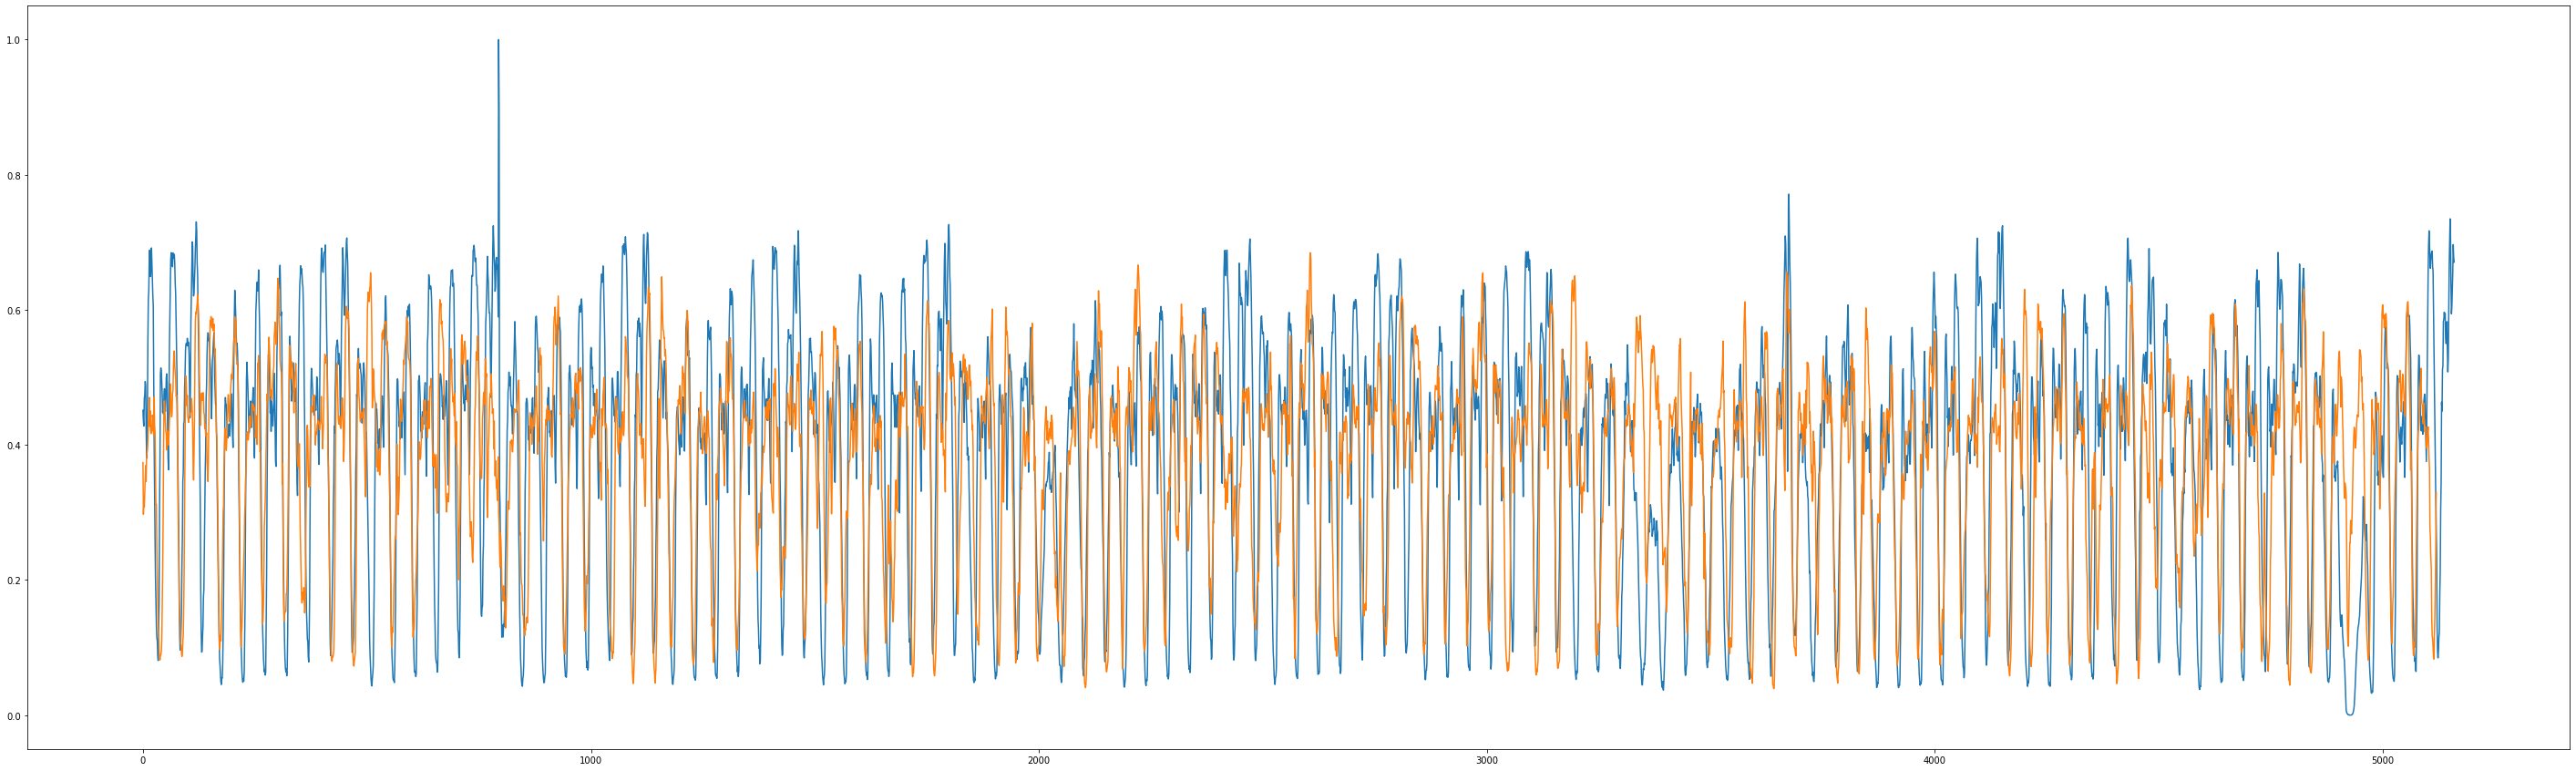

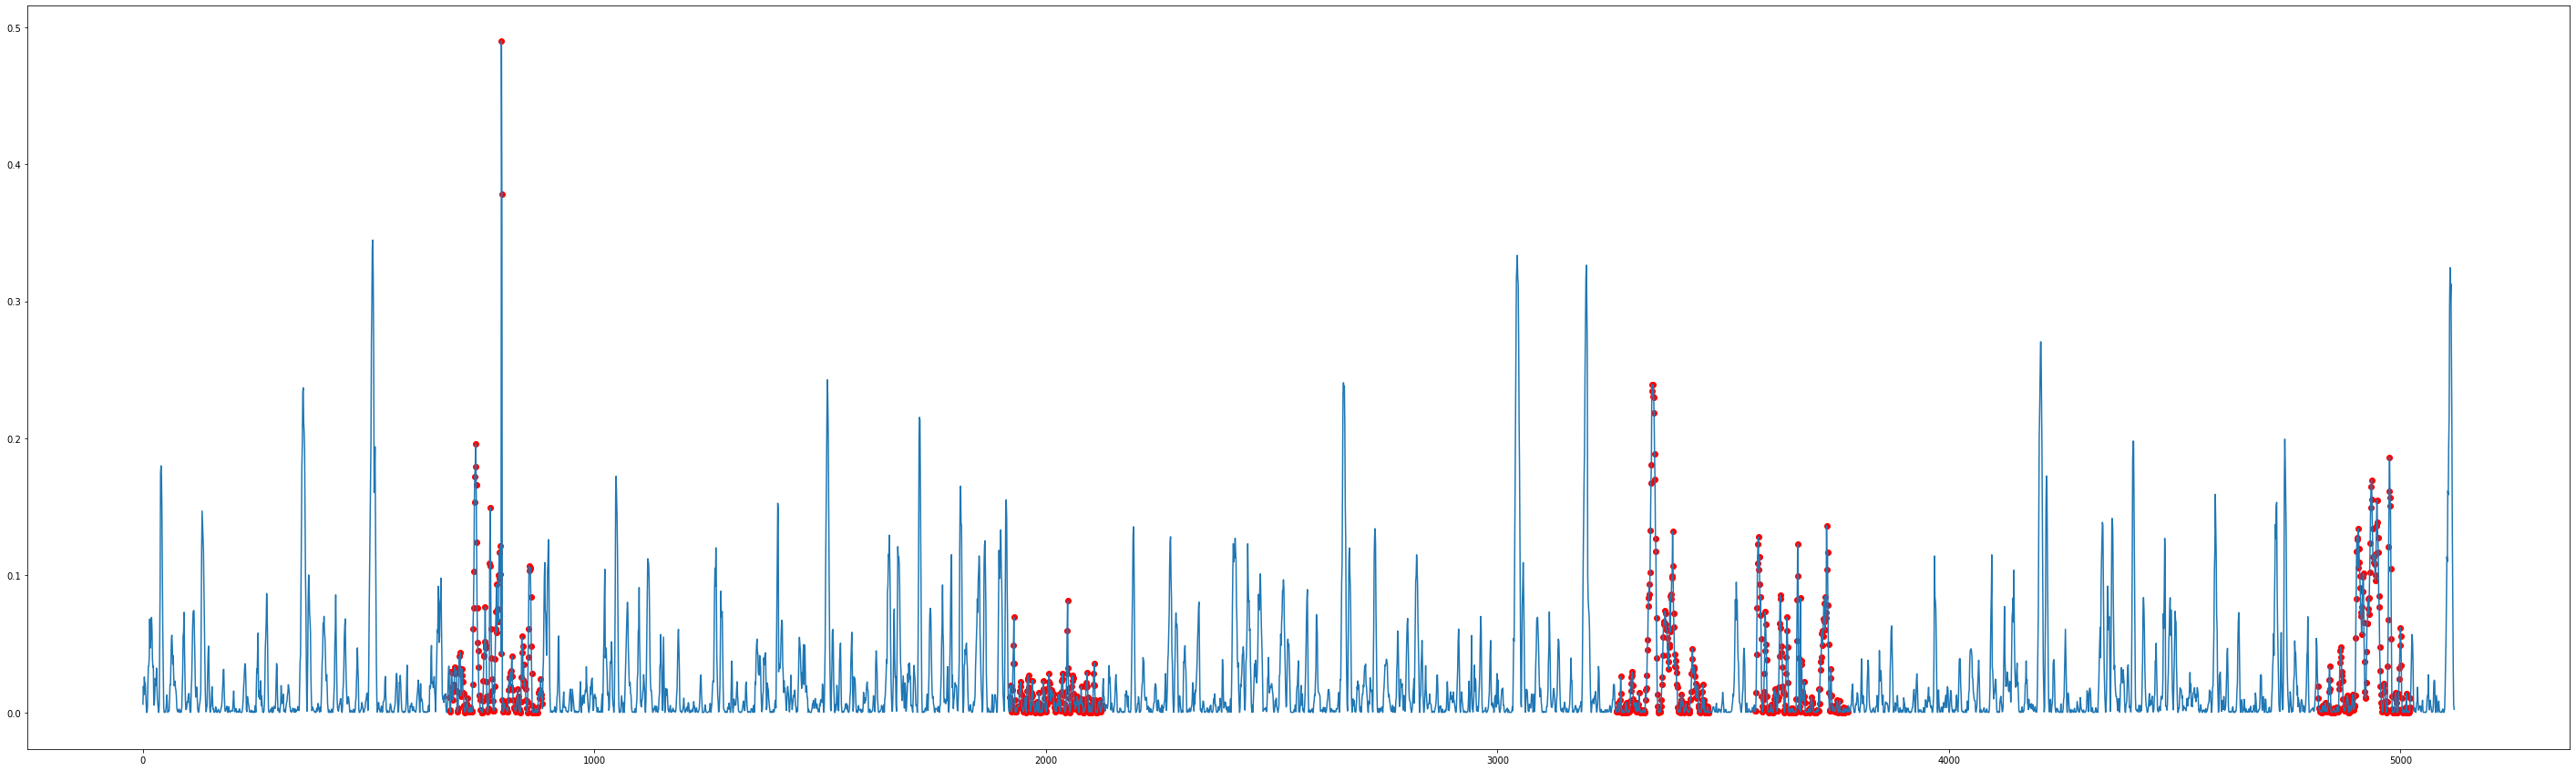

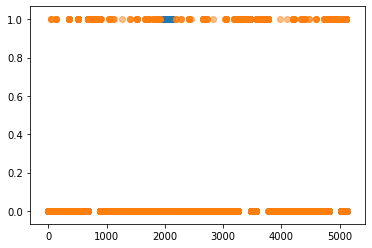

precision : 0.8110236220472441 recall : 0.8
aupr : 0.21948008715184802


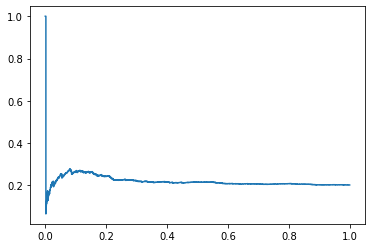

In [50]:
real = np.zeros(len(X_test_data), dtype=np.int)
anomaly_idxs_test = anomaly_idxs - len(X_train_data)
real[anomaly_idxs_test] = 1

preds = evaluate_model(model, X_test_tensor)
plot_error_and_anomaly_idxs(X_test_data, preds, anomaly_idxs_test)

real = real[:len(preds)]

scores = (preds - X_test_data[:len(preds)])**2

thresh = np.quantile(scores, .95)

anomaly_preds = evaluate_anomalies(real, scores, thresh)

plt.scatter(np.arange(len(real)),real,alpha=.5)
plt.scatter(np.arange(len(real)),anomaly_preds,alpha=.5)

plt.show()



#rates:
precision = precision_score(real, anomaly_preds)
recall = recall_score(real, anomaly_preds)
f1 = f1_score(real, anomaly_preds)
print('precision : ' + str(precision) + ' recall : ' + str(recall))

precision, recall, thresholds = precision_recall_curve(real, scores)

#todo later
aupr_scores = np.copy(scores)
aupr = average_precision_score(real,scores)

print('aupr : ' + str(aupr))

plt.plot(recall, precision)
plt.show()

# donut example


In [10]:

real = np.array([0,0,1,1,1,0,0,1,1,1])
score = np.array([.6,.4,.3,.7,.6,.5,.2,.3,.4,.3])

thresh = .5
pointwise_alert = np.array([1 if score[i] > thresh else 0 for i in range(len(score))])

anomaly_windows = []
i = 0
while i < len(real):
    if real[i] == 1:
        j = i
        while(j < len(real)):
            if real[j] == 0:
                anomaly_windows.append([i,j])
                break
            j+=1
            
            if j == len(real)-1 and real[j] == 1:
                anomaly_windows.append([i,j+1])
                break                
            
        i = j-1


    i+=1

print(anomaly_windows)

adjusted_alert = np.copy(pointwise_alert)
for aw in anomaly_windows:
    if pointwise_alert[aw[0]:aw[1]].any() == 1:
        adjusted_alert[aw[0]:aw[1]] = 1

print(real)
print(score)
print(pointwise_alert)
print(adjusted_alert)


#rates

[[2, 5], [7, 10]]
[0 0 1 1 1 0 0 1 1 1]
[0.6 0.4 0.3 0.7 0.6 0.5 0.2 0.3 0.4 0.3]
[1 0 0 1 1 0 0 0 0 0]
[1 0 1 1 1 0 0 0 0 0]
